In [1]:
import torch
import torchvision
from torchvision import transforms, models, datasets

import numpy as np
import matplotlib.pyplot as plt
import os
import copy

device = torch.device("cuda : 0") if torch.cuda.is_available() else print("cpu")

print("Torch Version: {} \nTorchVision Version: {}".format(torch.__version__, torchvision.__version__))

cpu
Torch Version: 1.10.0+cu102 
TorchVision Version: 0.11.1+cu102


/home/isack/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
data_dir="/home/isack/Desktop/PyCon Tanzania 2021/data"

transform = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225])
    ])
}

dataset = {x: datasets.ImageFolder(root = os.path.join(data_dir, x), transform = transform[x]) for x in ["train", "val"]}

dataloader = {x: torch.utils.data.DataLoader(dataset[x], batch_size = 4, shuffle=True, num_workers= 0) for x in ["train", "val"]}

dataset_sizes = {x: len(dataset[x]) for x in ["train","val"]}

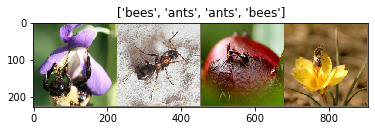

In [3]:
def show(imgs, title=None):
    np_imgs = imgs.numpy().transpose(1, 2, 0)
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]
    np_imgs= np_imgs*std + mean
    
    np_imgs= np.clip(np_imgs, 0, 1)
    plt.imshow(np_imgs)
    plt.title(title)
    
inputs, labels = next(iter(dataloader["val"]))
imgs = torchvision.utils.make_grid(inputs)

show(imgs, title = [dataset["val"].classes[x] for x in labels])

In [4]:
def NN(model, optimizer, criterion, scheduler, dataset_size, num_epoch):
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        
        epoch_loss = 0.0
        epoch_acc = 0
        
        print("{}/{}".format(epoch+1, num_epoch))
        
        for phase in ["train","val"]:
            if phase =="train":
                model.train()
                
            if phase == "val":
                model.eval()
            
            running_loss = 0.0
            running_acc = 0
            
            for inputs, labels in dataloader[phase]:
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    
                    #Forward Propagation
                    output = model(inputs)
                    _,pred = torch.max(output, 1)
                    
                    #Loss 
                    loss = criterion(output, labels.data)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                #Perform Statistic / To find our running LOss and Acc
                running_loss += loss.item() * inputs.size(0)
                running_acc += torch.sum(pred == labels.data)
                
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_acc / dataset_size[phase]

            if phase == "train":
                scheduler.step()
                
            print("Phase: {}  Epoch Loss : {:.4f}  Epoch Acc : {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
                
            
        print()
        
    print("Best Acc : {}".format(best_acc))
    
    model.load_state_dict(best_model)
    
    return model
            

In [5]:
model =models.resnet152(pretrained=True)

In [6]:
for params in model.parameters():
    params.requires_grad = False

In [7]:
for names, params in model.named_parameters():
    if params.requires_grad == True:
        print(names)

In [8]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [9]:
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 2, bias=True)

In [10]:
for names, params in model.named_parameters():
    if params.requires_grad == True:
        print(names)

fc.weight
fc.bias


In [11]:
optimizer = torch.optim.SGD(model.fc.parameters(), lr=1e-4, momentum=0.9)

criterion = torch.nn.CrossEntropyLoss()

lr_scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.1)

my_model = NN(model, optimizer=optimizer, criterion=criterion, scheduler=lr_scheduler, dataset_size=dataset_sizes, num_epoch=5)

1/5
Phase: train  Epoch Loss : 0.7073  Epoch Acc : 0.4000
Phase: val  Epoch Loss : 0.7778  Epoch Acc : 0.3438

2/5
Phase: train  Epoch Loss : 0.7032  Epoch Acc : 0.4000
Phase: val  Epoch Loss : 0.7433  Epoch Acc : 0.4688

3/5
Phase: train  Epoch Loss : 0.6881  Epoch Acc : 0.4333
Phase: val  Epoch Loss : 0.7303  Epoch Acc : 0.5000

4/5
Phase: train  Epoch Loss : 0.6731  Epoch Acc : 0.6000
Phase: val  Epoch Loss : 0.7194  Epoch Acc : 0.5000

5/5
Phase: train  Epoch Loss : 0.6917  Epoch Acc : 0.5667
Phase: val  Epoch Loss : 0.7101  Epoch Acc : 0.4375

Best Acc : 0.5


In [12]:
#saving  model
path= "/home/isack/Desktop/PyCon Tanzania 2021/saved_model/resnet152.pth"

model = torch.save(model, path)